In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

# Load Data

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Data science/Final Project/Data Online Retail Year_2009-2011.csv')

# Background and Objectives

Currently, online retail players are fiercely competing to win and retain customers, is an expensive affair. That is why it is crucial for success to invest primarily in those customers who are lucrative for the company in the long run. It is important to understand these customers intimately, to engage them with the right channels, and to tailor offers to their context and needs. This can only be achieved by drawing on customer related metrics of which customer lifetime value (CLV) is first among equals and by interlinking them intelligently as the foundation for effective and efficient marketing <br>
<br>
In this project I will discuss how RFM segmentation and CLTV analysis can optimise marketing.

# Dataset Description

About Dataset : <br>
    A real online retail transaction data set of two years. <br>
    This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers. <br>

Column Description :
* InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
* StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
* Description: Product (item) name. Nominal.
* Quantity: The quantities of each product (item) per transaction. Numeric.
* InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.
* UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).
* CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
* Country: Country name. Nominal. The name of the country where a customer resides.
    

# Preliminary Look and Data Cleansing

## Sample of Data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044848 entries, 0 to 1044847
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1044848 non-null  object 
 1   StockCode    1044848 non-null  object 
 2   Description  1040573 non-null  object 
 3   Quantity     1044848 non-null  int64  
 4   InvoiceDate  1044848 non-null  object 
 5   Price        1044848 non-null  float64
 6   Customer ID  809561 non-null   float64
 7   Country      1044848 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 63.8+ MB


In [5]:
data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/2009 7:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/2009 7:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/2009 7:45,1.25,13085.0,United Kingdom


In [6]:
data.shape

(1044848, 8)

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,1044848.0,9.993649,174.218493,-80995.00,1.00,3.0,10.00,80995.0
Price,1044848.0,4.590546,121.704167,-53594.36,1.25,2.1,4.13,38970.0
Customer ID,809561.0,15319.760422,1695.812057,12346.00,13969.00,15248.0,16792.00,18287.0


* This dataset contains 1044848 Row and 8 Columns
* There are several columns that have missing values.
* `InvoiceDate` should be datetime
* `Price` column should not be negative
* Delete `Invoice` starts with the letter `c`, it indicates a cancellation.


In [8]:
PO = data[data['Price'] <= 0]

In [9]:
PO

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,12/1/2009 10:52,0.0,NaN,United Kingdom
283,489463,71477,short,-240,12/1/2009 10:52,0.0,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,12/1/2009 10:53,0.0,NaN,United Kingdom
470,489521,21646,NaN,-50,12/1/2009 11:44,0.0,NaN,United Kingdom
3114,489655,20683,NaN,-44,12/1/2009 17:26,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
1039919,581234,72817,NaN,27,12/8/2011 10:33,0.0,NaN,United Kingdom
1041442,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,12/8/2011 13:58,0.0,NaN,United Kingdom
1041443,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,12/8/2011 13:58,0.0,NaN,United Kingdom
1041492,581408,85175,NaN,20,12/8/2011 14:06,0.0,NaN,United Kingdom


In [10]:
# Change the Invoice column to date time format and delete 0 values that are less than 0
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data = data[(data['Price'] > 0)]

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1038819 entries, 0 to 1044847
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1038819 non-null  object        
 1   StockCode    1038819 non-null  object        
 2   Description  1038819 non-null  object        
 3   Quantity     1038819 non-null  int64         
 4   InvoiceDate  1038819 non-null  datetime64[ns]
 5   Price        1038819 non-null  float64       
 6   Customer ID  809491 non-null   float64       
 7   Country      1038819 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 71.3+ MB


## Missing values

In [12]:
# number of missing values per column
data.isna().sum()

Invoice             0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
Price               0
Customer ID    229328
Country             0
dtype: int64

In [13]:
# percentage version
data.isna().sum() * 100 / len(data)

Invoice         0.000000
StockCode       0.000000
Description     0.000000
Quantity        0.000000
InvoiceDate     0.000000
Price           0.000000
Customer ID    22.075838
Country         0.000000
dtype: float64

In [14]:
# Portion missing values considering all columns
((data.shape[0] - data.dropna().shape[0])/data.shape[0])*100

22.075838043008456

In [15]:
CID_NULL = data[data['Customer ID'].isnull()]
print(CID_NULL['Description'].value_counts(), '\n')

DOTCOM POSTAGE                       1402
JUMBO BAG RED RETROSPOT               671
JUMBO STORAGE BAG SUKI                624
REGENCY CAKESTAND 3 TIER              615
PARTY BUNTING                         608
                                     ... 
SKULLS WRAP                             1
ACRYLIC JEWEL ANGEL,BLUE                1
EDWARDIAN PHOTO FRAME                   1
PURPLE ANEMONE ARTIFICIAL FLOWER        1
GOLD COSMETICS BAG WITH BUTTERFLY       1
Name: Description, Length: 4587, dtype: int64 



The dataset has 22.07% missing values, which are found in features `Customer ID`, I will fill null value in Customer ID with `User Non Login`

In [16]:
# fill null value in Customer ID
data['Customer ID'].fillna('User Non Login', inplace=True)

In [17]:
# Sanity checking
data.isna().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

## Duplicate Data

In [18]:
# number of duplicated data
print("Number of duplicates before cleaning:",data.duplicated().sum())
data = data.drop_duplicates(keep="first")
print("Number of duplicates after cleaning:",data.duplicated().sum())

Number of duplicates before cleaning: 11802
Number of duplicates after cleaning: 0


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1027017 entries, 0 to 1044847
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1027017 non-null  object        
 1   StockCode    1027017 non-null  object        
 2   Description  1027017 non-null  object        
 3   Quantity     1027017 non-null  int64         
 4   InvoiceDate  1027017 non-null  datetime64[ns]
 5   Price        1027017 non-null  float64       
 6   Customer ID  1027017 non-null  object        
 7   Country      1027017 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 70.5+ MB


Now data is Clean

# Data Understanding

## Statistical summary

In [20]:
# group column names based on type
numericals = data.select_dtypes(include=[np.number]).columns
categoricals = data.select_dtypes(exclude=[np.number]).columns

In [21]:
# numerical statistical sumary
data[numericals].describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,1027017.0,10.446107,168.633972,-80995.000,1.00,3.0,10.00,80995.0
Price,1027017.0,4.795523,93.108053,0.001,1.25,2.1,4.15,38970.0


In [22]:
cols = ['Quantity', 'Price', 'Customer ID']
for col in cols:
  print(f"Value counts of {col} column")
  print(data[col].value_counts(), '\n')

Value counts of Quantity column
 1        277336
 2        154796
 12       119225
 6         83044
 4         70620
           ...  
-3936          1
-2976          1
-1632          1
-7008          1
-80995         1
Name: Quantity, Length: 726, dtype: int64 

Value counts of Price column
1.25      100898
1.65       71336
0.85       66697
2.95       63317
0.42       44305
           ...  
103.92         1
134.96         1
1.77           1
144.35         1
224.69         1
Name: Price, Length: 2802, dtype: int64 

Value counts of Customer ID column
User Non Login    229202
17841.0            12638
14911.0            11442
12748.0             6660
14606.0             6500
                   ...  
12570.0                1
17077.0                1
17336.0                1
13120.0                1
16220.0                1
Name: Customer ID, Length: 5940, dtype: int64 



In [23]:
# describe categorical data
data[categoricals].describe().T

,count,unique,top,freq,first,last
Invoice,1027017,48369,573585,1114,NaT,NaT
StockCode,1027017,4932,85123A,5645,NaT,NaT
Description,1027017,5415,WHITE HANGING HEART T-LIGHT HOLDER,5735,NaT,NaT
InvoiceDate,1027017,44341,2011-10-31 14:41:00,1114,2009-12-01 07:45:00,2011-12-09 12:50:00
Customer ID,1027017,5940,User Non Login,229202,NaT,NaT
Country,1027017,43,United Kingdom,942329,NaT,NaT


In [24]:
# showing the precise value counts
for col in categoricals:
  print(f"Value counts of {col} column")
  print(data[col].value_counts(), '\n')

Value counts of Invoice column
573585     1114
581219      749
581492      731
580729      721
558475      705
           ... 
C518678       1
C538704       1
C538703       1
C538702       1
C526537       1
Name: Invoice, Length: 48369, dtype: int64 

Value counts of StockCode column
85123A    5645
22423     4291
85099B    4126
21212     3209
20725     3170
          ... 
17061        1
85230C       1
85230D       1
16169A       1
16192        1
Name: StockCode, Length: 4932, dtype: int64 

Value counts of Description column
WHITE HANGING HEART T-LIGHT HOLDER    5735
REGENCY CAKESTAND 3 TIER              4291
JUMBO BAG RED RETROSPOT               3384
ASSORTED COLOUR BIRD ORNAMENT         2867
PARTY BUNTING                         2728
                                      ... 
F FAIRY POTPOURRI CUSHIONS SUMMER        1
WALL ART , THE MAGIC FOREST              1
TRAY FOR TV DINNER , DOLLY GIRL          1
PEN, 10 COLOURS - SPACEBOY               1
ENAMEL DINNER PLATE PANTRY             

* `Quantity`, `Price` features have a mean > median value, which indicates that the features tend to have a positively skewed distribution.

# Univariate Analysis

## Numericals Feature

### Boxplot to detect outliers

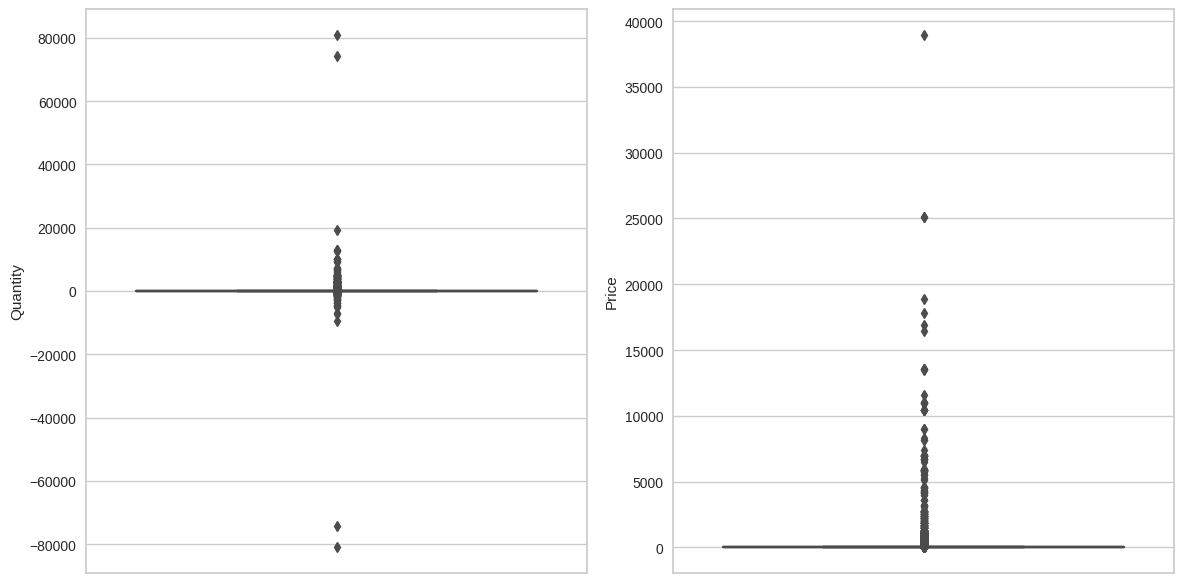

In [25]:
plt.figure(figsize=(12, 6))
features = numericals
for i in range(0, len(features)):
    plt.subplot(1, len(features), i + 1)
    sns.boxplot(y=data[features[i]], color='red')
    plt.tight_layout()

In [26]:
# Calculates Q1 and Q3 for each column
Q1_quantity = data['Quantity'].quantile(0.25)
Q3_quantity = data['Quantity'].quantile(0.75)

Q1_price = data['Price'].quantile(0.25)
Q3_price = data['Price'].quantile(0.75)

# Calculates IQR for each column
IQR_quantity = Q3_quantity - Q1_quantity
IQR_price = Q3_price - Q1_price

# Determine the upper limit and lower limit for each column
lower_bound_quantity = Q1_quantity - 1.5 * IQR_quantity
upper_bound_quantity = Q3_quantity + 1.5 * IQR_quantity

lower_bound_price = Q1_price - 1.5 * IQR_price
upper_bound_price = Q3_price + 1.5 * IQR_price

# Identify outliers for each column
outliers_quantity = (data['Quantity'] < lower_bound_quantity) | (data['Quantity'] > upper_bound_quantity)
outliers_price = (data['Price'] < lower_bound_price) | (data['Price'] > upper_bound_price)

# Filter the DataFrame to include only outliers
df_outliers = data[outliers_quantity | outliers_price]

In [27]:
df_outliers.sort_values(by='Price', ascending=False)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
725619,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.00,15098.0,United Kingdom
241824,C512770,M,Manual,-1,2010-06-17 16:52:00,25111.09,17399.0,United Kingdom
241827,512771,M,Manual,1,2010-06-17 16:53:00,25111.09,User Non Login,United Kingdom
320581,C520667,BANK CHARGES,Bank Charges,-1,2010-08-27 13:42:00,18910.69,User Non Login,United Kingdom
1027540,C580605,AMAZONFEE,AMAZON FEE,-1,2011-12-05 11:36:00,17836.46,User Non Login,United Kingdom
...,...,...,...,...,...,...,...,...
507225,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.03,15838.0,United Kingdom
358773,524174,16053,POPART COL BALLPOINT PEN ASST,2000,2010-09-27 16:30:00,0.03,13687.0,United Kingdom
359659,C524235,16053,POPART COL BALLPOINT PEN ASST,-2000,2010-09-28 11:02:00,0.03,14277.0,France
611026,C545478,D,Discount,-720,2011-03-03 11:08:00,0.01,16422.0,United Kingdom


The data makes sense, because I didn't delete the canceled order data, so there is a negative quantity which means canceled order.

### KDE plot for knowing the distribution form

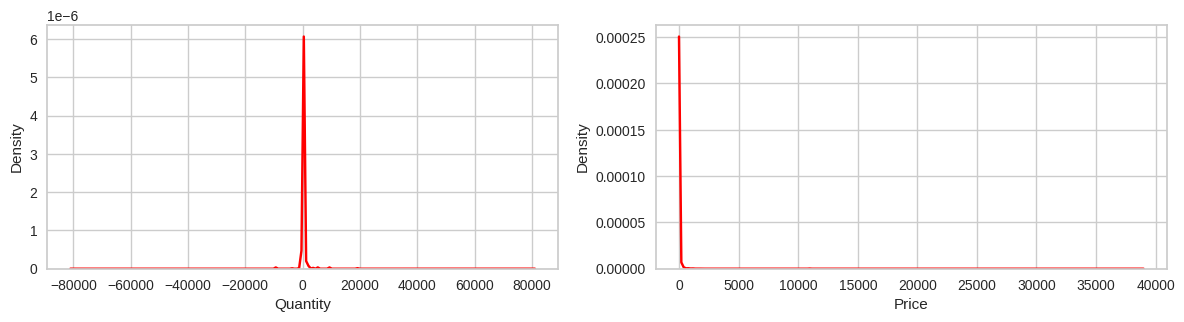

In [28]:
# adjust the figure size for better readability
plt.figure(figsize=(12,6))

features = numericals
for i in range(0, len(features)):
    plt.subplot(2, len(features)//2 + 1, i+1)
    sns.kdeplot(x=data[features[i]], color='red')
    plt.xlabel(features[i])
    plt.tight_layout()

## Categorical Features

In [29]:
Country = data['Country'].value_counts().sort_values(ascending=False)
Invoice_Year = pd.to_datetime(data['InvoiceDate']).dt.year

In [30]:
Country

United Kingdom          942329
EIRE                     17662
Germany                  17331
France                   14024
Netherlands               5132
Spain                     3753
Switzerland               3174
Belgium                   3109
Portugal                  2528
Australia                 1887
Channel Islands           1646
Italy                     1507
Sweden                    1362
Norway                    1307
Cyprus                    1157
Finland                   1049
Austria                    938
Denmark                    797
Unspecified                752
Greece                     663
Japan                      565
USA                        535
Poland                     527
United Arab Emirates       500
Israel                     368
Hong Kong                  360
Singapore                  346
Malta                      299
Canada                     228
Iceland                    222
RSA                        168
Lithuania                  154
Bahrain 

In [31]:
fig = px.bar(Country, x=Country.values, y=Country.index, template='seaborn')
fig.update_xaxes(title='Invoice')
fig.update_yaxes(title='Country')

fig.show()


<Axes: xlabel='InvoiceDate', ylabel='count'>

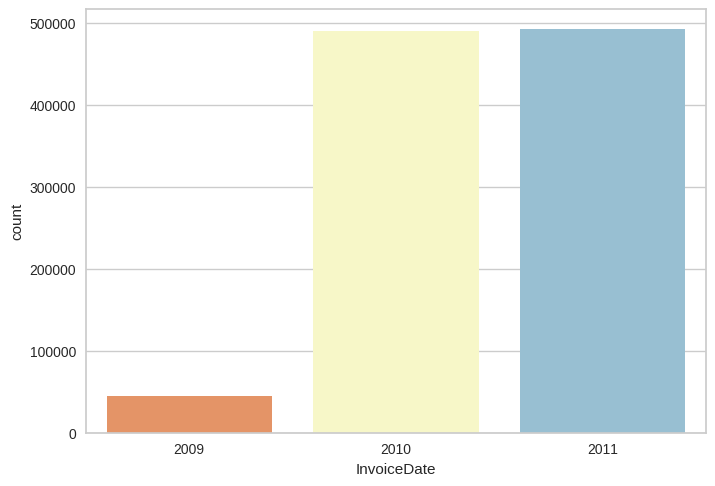

In [32]:
fig, ax = plt.subplots,figsize=(10,10)
sns.countplot(x=Invoice_Year, palette=('RdYlBu'))

Observation :<br>
* Most orders came from the UK, EIRE, Germany, France
* The most orders were placed in 2011

# Multivariate Analysis

## Heatmap

In [33]:
numeric_dat = data.select_dtypes(include='number')
fig = px.imshow(numeric_dat.corr(), x=numeric_dat.columns, y=numeric_dat.columns, zmin=-1, zmax=1, color_continuous_scale='Viridis')
fig.update_layout(title='Correlation Heatmap', width=800, height=800)
fig.show()

In [34]:
numeric_dat.corr()

,Quantity,Price
Quantity,1.000000,-0.002011
Price,-0.002011,1.000000


there is no corerelation between features

# Deep Dive EDA

Deep Dive Question : <br>
1. Sales Seasonality <br>
2. Top 10 Customer With The Highest Transaction Value <br>
3. Top 5 Country With Most The Customers <br>
4. Top 10 Product Purchases

## Sales Seasonality

In [35]:
df_temp = data.copy()
df_temp['InvoiceMonth'] = df_temp['InvoiceDate'].apply(lambda x: dt.datetime(x.year, x.month, 1))
df_temp['Total_Sales'] = df_temp['Quantity'] * df_temp['Price']

# Group by and calculate mean
sale_month = df_temp.groupby(['InvoiceMonth'])[['Quantity', 'Price', 'Total_Sales']].mean().reset_index()

fig = px.line(sale_month, x='InvoiceMonth', y=['Quantity', 'Price', 'Total_Sales'],
              labels={'value': 'Average', 'variable': 'Metric'},
              title='Sales Seasonality',
              template='seaborn',
              width=1500, height=900)
# Set x-axis properties
fig.update_xaxes(tickmode='array', tickvals=sale_month['InvoiceMonth'],
                 ticktext=sale_month['InvoiceMonth'].dt.strftime('%b\n%Y').tolist(),
                 tickangle=45)

# Set y-axis properties
fig.update_yaxes(range=[0, max(sale_month[['Quantity', 'Price', 'Total_Sales']].max()) * 1.2], nticks=15)

fig.show()

* Based on the data, it is clear that the most significant drop in total sales occurs every September - December.<br>
<br>
There are several factors related to the decline in sales from September to December, one of which is that many people in the UK have started preparing for holiday spending. This may lead to a decrease in spending on non-essential items, such as gifts. Another factor is the competition in offering promotions and discounts to attract customers. This can lead to a decline in sales for retailers who do not offer competitive promotions or discounts, hence the need for competitor data and longer sales data to see the cause of the decline.


## Top 10 Customer With The Highest Transaction Value

In [36]:
df_temp1=data.copy()
df_temp1["TotalCost"] = df_temp1["Quantity"] * df_temp1["Price"]

In [37]:
# Top 10 Customer with the highest transaction value
Top10_cust = (df_temp1
            .groupby('Customer ID')
            .agg(SalesTotal=('TotalCost','sum'))
            .reset_index()
            .sort_values('SalesTotal', ascending = False)
            .head(11))
Top10_cust

,Customer ID,SalesTotal
5939,User Non Login,2724218.55
5753,18102.0,570380.61
2298,14646.0,523342.07
1808,14156.0,296063.44
2562,14911.0,265757.91
5101,17450.0,231390.55
1347,13694.0,190020.84
5162,17511.0,168491.62
69,12415.0,143269.29
4335,16684.0,141502.25


In [38]:
Cons_1 = df_temp1[df_temp1["Customer ID"] == 18102.0]
Cons_1

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalCost
54,489438,21329,DINOSAURS WRITING SET,28,2009-12-01 09:24:00,0.98,18102.0,United Kingdom,27.44
55,489438,21252,SET OF MEADOW FLOWER STICKERS,30,2009-12-01 09:24:00,1.69,18102.0,United Kingdom,50.70
56,489438,21100,CHARLIE AND LOLA CHARLOTTE BAG,30,2009-12-01 09:24:00,1.15,18102.0,United Kingdom,34.50
57,489438,21033,JUMBO BAG CHARLIE AND LOLA TOYS,30,2009-12-01 09:24:00,2.00,18102.0,United Kingdom,60.00
58,489438,20711,JUMBO BAG TOYS,60,2009-12-01 09:24:00,1.30,18102.0,United Kingdom,78.00
...,...,...,...,...,...,...,...,...,...
1043004,581457,23535,WALL ART BICYCLE SAFETY,126,2011-12-08 18:43:00,3.90,18102.0,United Kingdom,491.40
1043005,581457,23530,WALL ART ONLY ONE PERSON,126,2011-12-08 18:43:00,3.57,18102.0,United Kingdom,449.82
1043006,581457,23526,WALL ART DOG LICENCE,126,2011-12-08 18:43:00,3.90,18102.0,United Kingdom,491.40
1043007,581457,23401,RUSTIC MIRROR WITH LACE HEART,126,2011-12-08 18:43:00,4.15,18102.0,United Kingdom,522.90


Customer ID 18102.0 has a very high total transaction value (570380.61), and is domiciled in UK.

## Top 5 Country With Most The Customers

In [39]:
# Top 5 Country With Most The Customers
df_temp2 = df_temp1.copy()
top_5 = df_temp2.groupby("Country")["Customer ID"].nunique().sort_values(ascending=False)
Top_5_Country = top_5.head(5)

fig = px.bar(Top_5_Country, x=Top_5_Country.index, y=Top_5_Country.values, width=1000, height=600, template='seaborn')
# Set axis labels
fig.update_xaxes(title='Top 5 Country')
fig.update_yaxes(title='count')

fig.show()

The most customers came from the UK with 5408 customers, Germany with 107 customers, France with 96 customers, Spain with 41 customers, and Belgium with 29 customers.

## Top 10 Product Purchases

In [40]:
# Top 10 Product Purchases
df_temp3 = data.copy()
top_10_products = df_temp3.groupby("Description")["Quantity"].sum().sort_values(ascending=False).head(10).reset_index()
top_10_products.rename(columns={'Description': 'Product',
                         'Quantity': 'Total Sold'}, inplace=True)
top_10_products

,Product,Total Sold
0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,104435
1,WHITE HANGING HEART T-LIGHT HOLDER,91021
2,ASSORTED COLOUR BIRD ORNAMENT,79571
3,JUMBO BAG RED RETROSPOT,76508
4,BROCADE RING PURSE,69629
5,PACK OF 60 PINK PAISLEY CAKE CASES,55842
6,60 TEATIME FAIRY CAKE CASES,53678
7,SMALL POPCORN HOLDER,48198
8,PACK OF 72 RETROSPOT CAKE CASES,47695
9,PACK OF 72 RETRO SPOT CAKE CASES,46079


In [41]:
fig = px.bar(top_10_products, x=top_10_products['Total Sold'], y=top_10_products['Product'], template='seaborn')
fig.update_layout(title='Top 10 Products', yaxis_title='Products', width=1100, height=700, template='seaborn')
fig.show()

# EDA Conclusion

1. The data does not contain major issues
2. Quantity has a normal distribution, because there are consumers who cancel the purchase of products, and Price features is positively skewed distribution.
3. Most orders came from the UK
4. The most orders were placed in 2011
5. Based on correlation heatmap there is no correlation between features
6. Based on the data, it is clear that the most significant drop in total sales occurs every September - December.  
7. There is one customer who has a very high total transaction value.<br>
    Customer ID 18102, transaction value (570380.61), <br>
    Domiciled in UK<br>
8. Top 10 Product :
    * WORLD WAR 2 GLIDERS ASSTD DESIGNS
    * WHITE HANGING HEART T-LIGHT HOLDER
    * ASSORTED COLOUR BIRD ORNAMENT
    * JUMBO BAG RED RETROSPOT
    * BROCADE RING PURSE
    * PACK OF 60 PINK PAISLEY CAKE CASES
    * 60 TEATIME FAIRY CAKE CASES
    * SMALL POPCORN HOLDER
    * PACK OF 72 RETROSPOT CAKE CASES
    * PACK OF 72 RETRO SPOT CAKE CASES
    

    
    



# RFM (Recency,Frequency, Monetary)

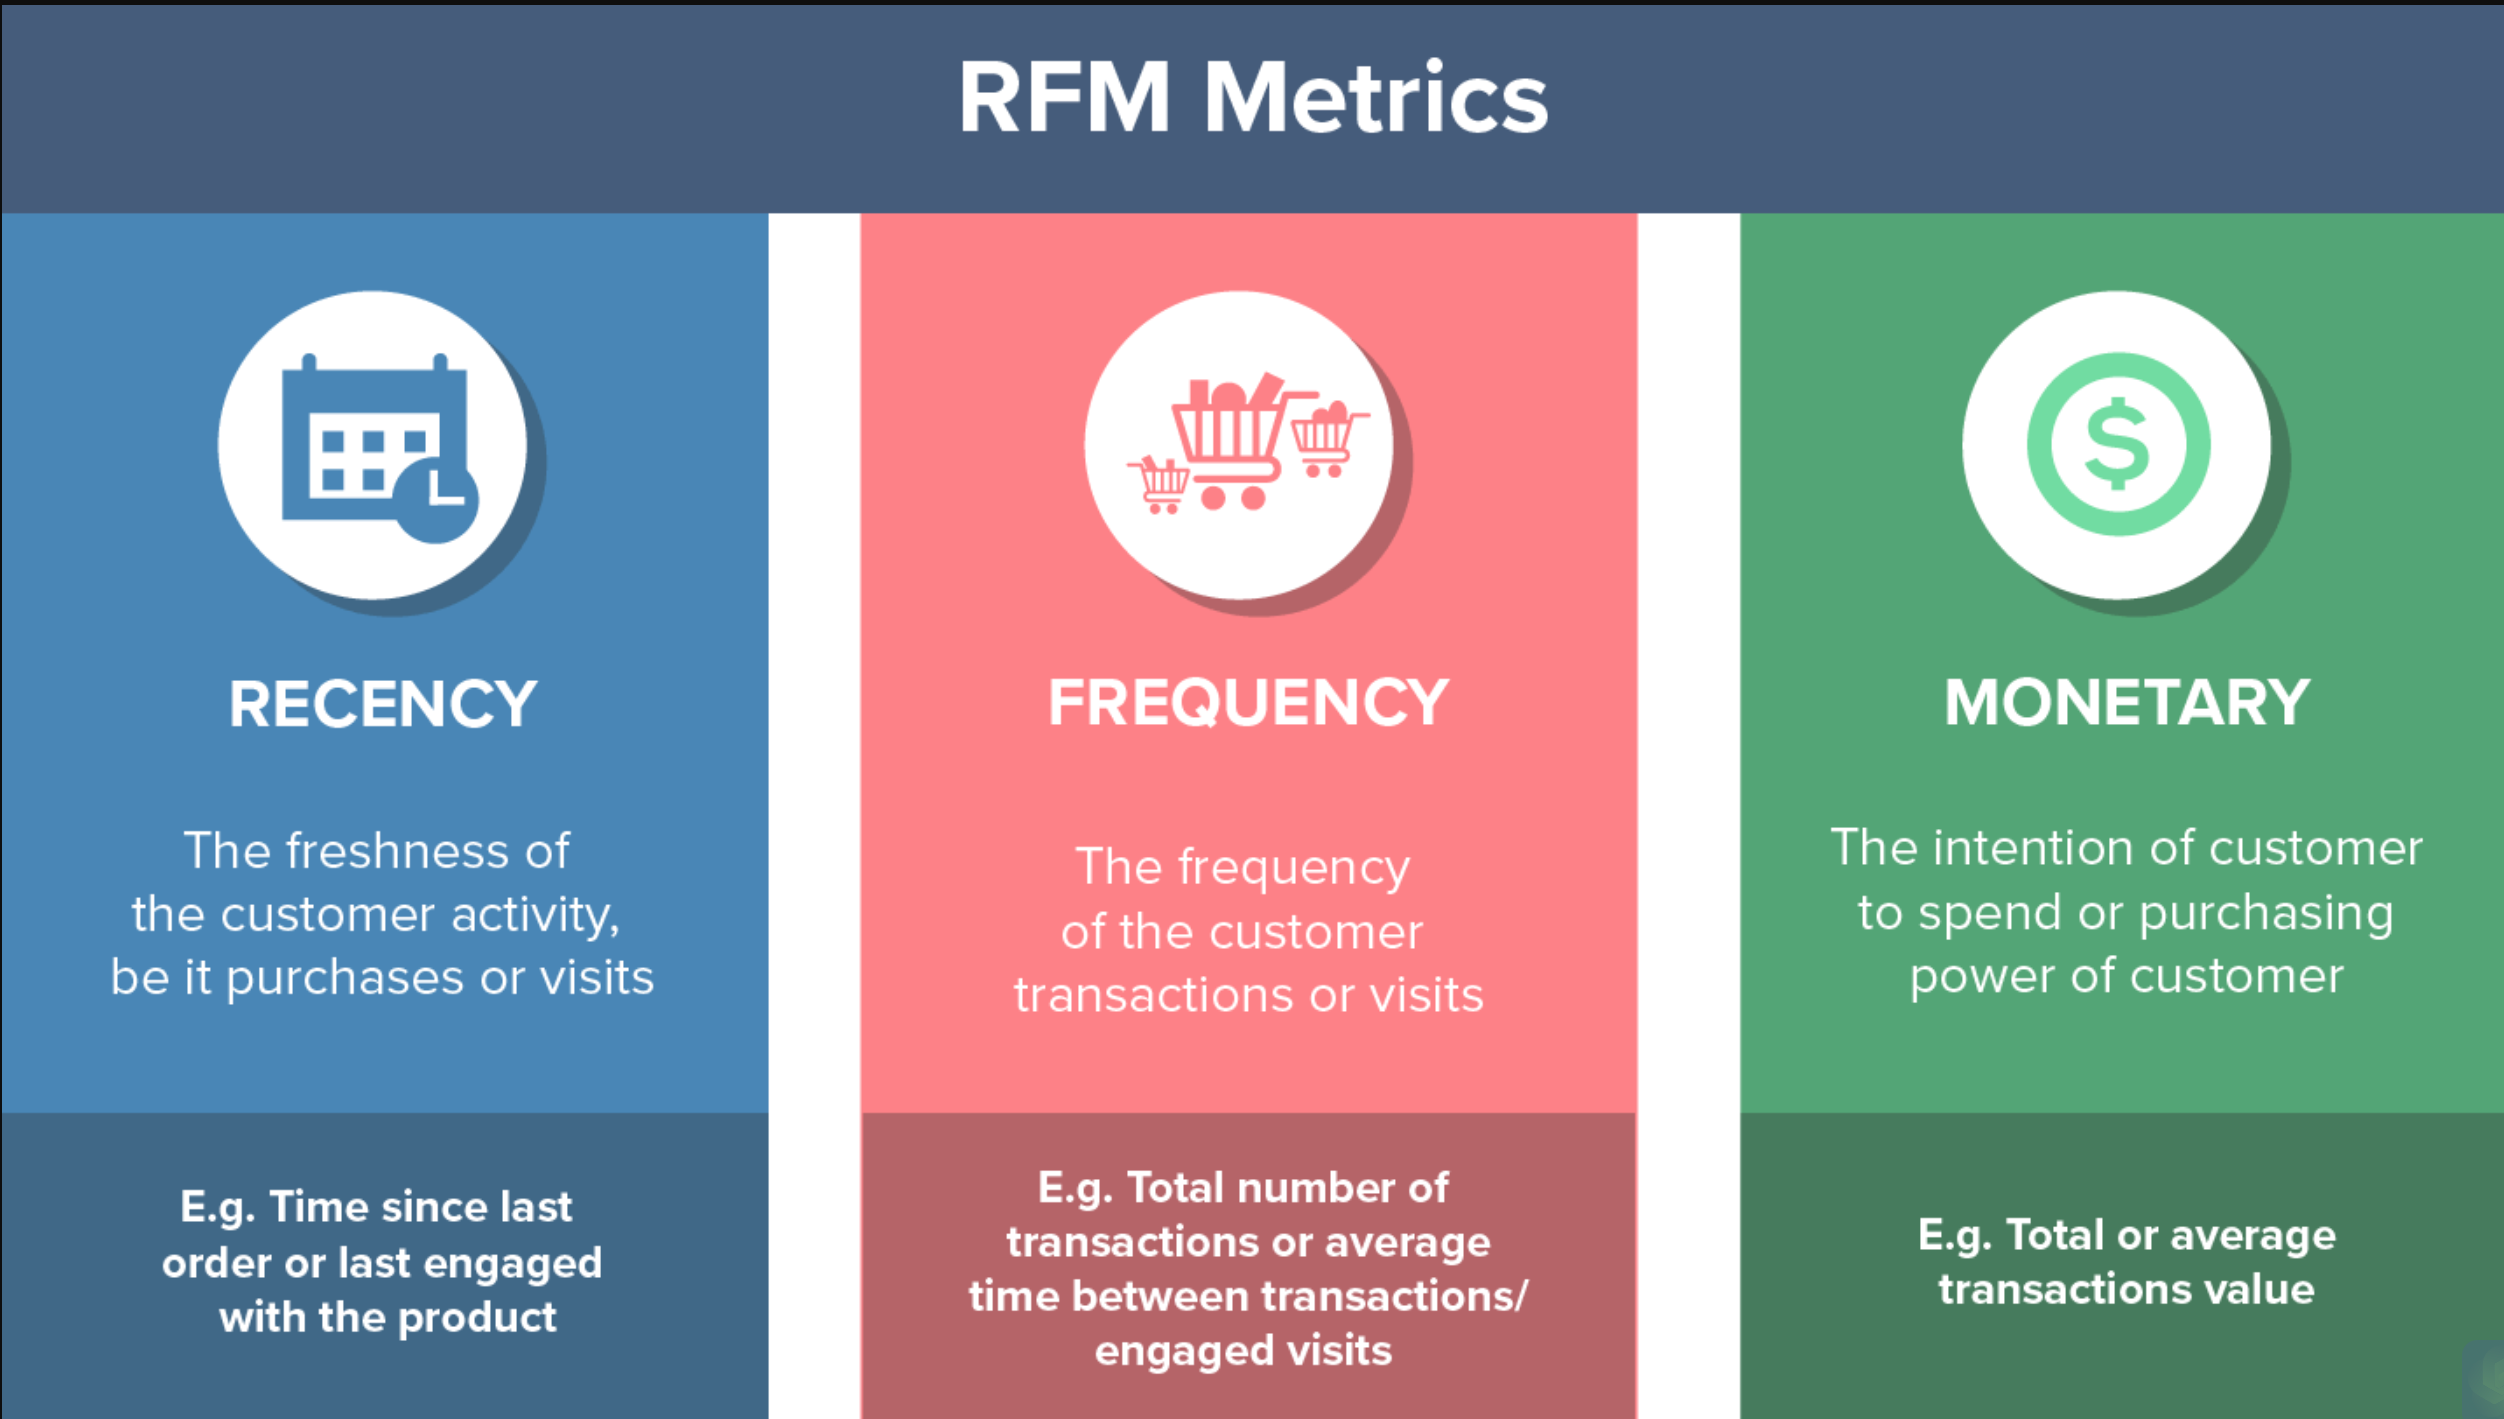

RFM stands for Recency, Frequency, and Monetary Value, and it is a marketing analysis technique used to understand and segment customers based on their transaction behaviors.

# Feature Engginering

In [42]:
# Creating new feature `TotalCost`
data["TotalCost"] = data["Quantity"] * data["Price"]

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1027017 entries, 0 to 1044847
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1027017 non-null  object        
 1   StockCode    1027017 non-null  object        
 2   Description  1027017 non-null  object        
 3   Quantity     1027017 non-null  int64         
 4   InvoiceDate  1027017 non-null  datetime64[ns]
 5   Price        1027017 non-null  float64       
 6   Customer ID  1027017 non-null  object        
 7   Country      1027017 non-null  object        
 8   TotalCost    1027017 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 78.4+ MB


In [44]:
print("Max date :",data["InvoiceDate"].max())
print("Min date :",data["InvoiceDate"].min())

Max date : 2011-12-09 12:50:00
Min date : 2009-12-01 07:45:00


In [45]:
# Set last date was 2011-12-09.
Last_Date = dt.datetime(2011,12,10)

## Create Feature Recency, Frequency, Montary

In [46]:
RFM = data.groupby('Customer ID').agg({'InvoiceDate': lambda x: (Last_Date - x.max()).days,
                                                 'Invoice': lambda x: x.nunique(),
                                                 "TotalCost": lambda x: x.sum()})

In [47]:
RFM.rename(columns={'InvoiceDate': 'Recency',
                         'Invoice': 'FrequencyTotal',
                         'TotalCost': 'Monetary'}, inplace=True)

In [48]:
df_feats = RFM.reset_index()

In [49]:
df_feats

,Customer ID,Recency,FrequencyTotal,Monetary
0,12346.0,325,17,-51.74
1,12347.0,2,8,4921.53
2,12348.0,75,5,2019.40
3,12349.0,18,5,4404.54
4,12350.0,310,1,334.40
...,...,...,...,...
5935,18284.0,429,2,436.68
5936,18285.0,660,1,427.00
5937,18286.0,476,3,1188.43
5938,18287.0,42,8,4177.89


To avoid bias in Frequency, I created a new column by separating cancelled orders and real orders.

In [50]:
# Create 'Cancelled' and 'RealOrder' columns
data['Cancelled'] = data['Invoice'].apply(lambda x: x if x.startswith('C') else None)
data['RealOrder'] = data['Invoice'].apply(lambda x: x if not x.startswith('C') else None)

summary_df = data.groupby('Customer ID').agg({
    'RealOrder': lambda x: x.dropna().nunique(),
    'Cancelled': lambda x: x.dropna().nunique()
})

In [51]:
summary_df

,RealOrder,Cancelled
Customer ID,,
12346.0,12,5
12347.0,8,0
12348.0,5,0
12349.0,4,1
12350.0,1,0
...,...,...
18284.0,1,1
18285.0,1,0
18286.0,2,1


In [52]:
df_feats = pd.merge(df_feats, summary_df, how='inner', on='Customer ID')

In [53]:
df_feats

,Customer ID,Recency,FrequencyTotal,Monetary,RealOrder,Cancelled
0,12346.0,325,17,-51.74,12,5
1,12347.0,2,8,4921.53,8,0
2,12348.0,75,5,2019.40,5,0
3,12349.0,18,5,4404.54,4,1
4,12350.0,310,1,334.40,1,0
...,...,...,...,...,...,...
5935,18284.0,429,2,436.68,1,1
5936,18285.0,660,1,427.00,1,0
5937,18286.0,476,3,1188.43,2,1
5938,18287.0,42,8,4177.89,7,1


In [54]:
df_feats.rename(columns={ 'RealOrder': 'Frequency'}, inplace=True)

In [55]:
df_feats

,Customer ID,Recency,FrequencyTotal,Monetary,Frequency,Cancelled
0,12346.0,325,17,-51.74,12,5
1,12347.0,2,8,4921.53,8,0
2,12348.0,75,5,2019.40,5,0
3,12349.0,18,5,4404.54,4,1
4,12350.0,310,1,334.40,1,0
...,...,...,...,...,...,...
5935,18284.0,429,2,436.68,1,1
5936,18285.0,660,1,427.00,1,0
5937,18286.0,476,3,1188.43,2,1
5938,18287.0,42,8,4177.89,7,1


In [56]:
df_feats = df_feats[df_feats['Customer ID'] != 'User Non Login']

In [57]:
df_feats.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,5939.0,202.333053,211.750530,0.00,24.000,95.00,381.00,738.00
FrequencyTotal,5939.0,7.555144,15.970199,1.00,2.000,4.00,8.00,510.00
Monetary,5939.0,2742.884541,13679.955199,-25111.09,321.365,823.53,2143.28,570380.61
Frequency,5939.0,6.224785,12.957940,0.00,1.000,3.00,7.00,398.00
Cancelled,5939.0,1.330359,3.653662,0.00,0.000,0.00,1.00,112.00


# Feature Standardization

In [58]:
feats = ['Recency', 'Frequency', 'Monetary']
X = df_feats[feats].values
X_std = StandardScaler().fit_transform(X)
new_df = pd.DataFrame(data = X_std, columns = feats)

In [59]:
RFM_nonScal = pd.DataFrame(data = X, columns = feats)

# Modeling

## Elbow Method & Silhouette Score

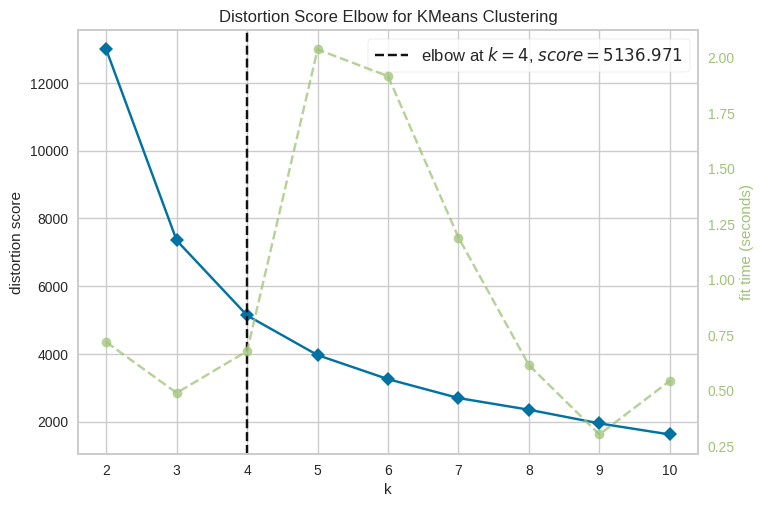

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [100]:
# Finding K value using Elbow Method
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(10), locate_elbow=True)
visualizer.fit(new_df)
visualizer.show()

Optimal number of clusters: 4


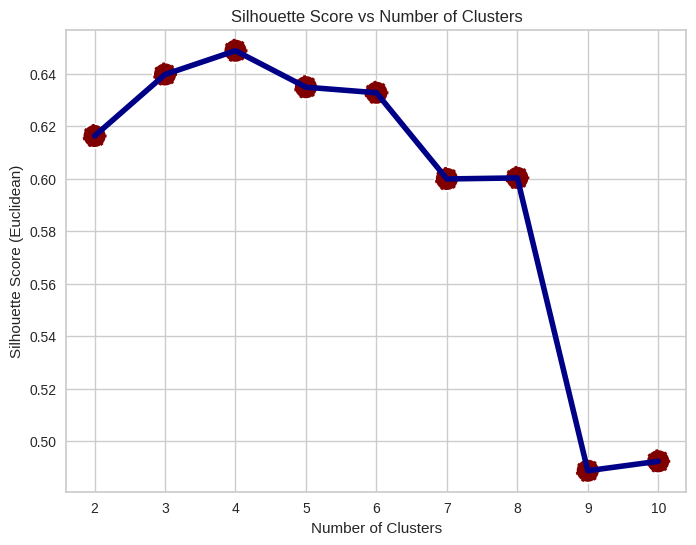

In [101]:
range_n_clusters = list(range(2, 11))

arr_silhouette_score_euclidean = []
for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i).fit(new_df)
    preds = kmeans.predict(new_df)
    score_euclidean = silhouette_score(new_df, preds, metric='euclidean')
    arr_silhouette_score_euclidean.append(score_euclidean)

# Plotting
plt.figure(figsize=(8, 6))
sns.lineplot(x=range(2, 11), y=arr_silhouette_score_euclidean, color='#000087', linewidth=4)
sns.scatterplot(x=range(2, 11), y=arr_silhouette_score_euclidean, s=300, color='#800000', linestyle='--')

# Adding labels and title
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score (Euclidean)')
plt.title('Silhouette Score vs Number of Clusters')

# Finding the optimal number of clusters
optimal_clusters = range_n_clusters[arr_silhouette_score_euclidean.index(max(arr_silhouette_score_euclidean))]
print(f'Optimal number of clusters: {optimal_clusters}')

# Display the plot

plt.show()

Based on the Elbow and Silhouette Method, it can be concluded that the optimal value of k is 4

## K-Means Clustering

In [62]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(new_df)
new_df['cluster'] = kmeans.labels_

In [63]:
new_df.head()

,Recency,Frequency,Monetary,cluster
0,0.579348,0.445727,-0.204303,1
1,-0.946160,0.137010,0.159272,0
2,-0.601386,-0.094528,-0.052891,0
3,-0.870593,-0.171707,0.121477,0
4,0.508504,-0.403245,-0.176074,1


# Visualization

In [64]:
new_df

,Recency,Frequency,Monetary,cluster
0,0.579348,0.445727,-0.204303,1
1,-0.946160,0.137010,0.159272,0
2,-0.601386,-0.094528,-0.052891,0
3,-0.870593,-0.171707,0.121477,0
4,0.508504,-0.403245,-0.176074,1
...,...,...,...,...
5934,-0.941437,1.217519,-0.005701,0
5935,1.070533,-0.403245,-0.168597,1
5936,2.161532,-0.403245,-0.169305,1
5937,1.292511,-0.326066,-0.113640,1


In [65]:
Group = new_df.groupby(['cluster'])[['Recency', 'Frequency', 'Monetary']].mean()

In [66]:
Group

,Recency,Frequency,Monetary
cluster,,,
0,-0.644853,0.079510,0.003239
1,1.245168,-0.318504,-0.156692
2,-0.942618,15.920168,30.056951
3,-0.851829,7.452352,5.013155


In [67]:
categories = ['Recency','Frequency','Monetary']
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=Group.iloc[0].to_list(),
      theta=categories,
      fill='toself',
      name='Need Attention'
))
fig.add_trace(go.Scatterpolar(
      r=Group.iloc[1].to_list(),
      theta=categories,
      fill='toself',
      name='At Risk'
))
fig.add_trace(go.Scatterpolar(
      r=Group.iloc[2].to_list(),
      theta=categories,
      fill='toself',
      name='The Champion'
))
fig.add_trace(go.Scatterpolar(
      r=Group.iloc[3].to_list(),
      theta=categories,
      fill='toself',
      name='Loyal Customers'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[-1, 31]
    )),
  showlegend=True,
  width=1000,
  height=1000
)

fig.show()

In [68]:
RFM_nonScal['cluster'] = kmeans.labels_
GroupRFM_nonScal = RFM_nonScal.groupby(['cluster'])[['Recency', 'Frequency', 'Monetary']].mean()

# List of metrics
metrics = ['Recency', 'Frequency', 'Monetary']

# Create a subplot with 1 row and len(metrics) columns
fig = make_subplots(rows=1, cols=len(metrics), subplot_titles=metrics)

# Loop through each metric and create a bar chart
for i, metric in enumerate(metrics, start=1):
    fig_i = px.bar(GroupRFM_nonScal, x=GroupRFM_nonScal.index, y=GroupRFM_nonScal[metric], width=1000, height=600, template='seaborn')
    fig.add_trace(fig_i['data'][0], row=1, col=i)

# Show the combined plot
fig.show()

0 = Need Attention <br>
1 = At Risk<br>
2 = The Champion<br>
3 = Loyal Customer

In [69]:
df_feats['cluster'] = kmeans.labels_

In [70]:
df_feats

,Customer ID,Recency,FrequencyTotal,Monetary,Frequency,Cancelled,cluster
0,12346.0,325,17,-51.74,12,5,1
1,12347.0,2,8,4921.53,8,0,0
2,12348.0,75,5,2019.40,5,0,0
3,12349.0,18,5,4404.54,4,1,0
4,12350.0,310,1,334.40,1,0,1
...,...,...,...,...,...,...,...
5934,18283.0,3,22,2664.90,22,0,0
5935,18284.0,429,2,436.68,1,1,1
5936,18285.0,660,1,427.00,1,0,1
5937,18286.0,476,3,1188.43,2,1,1


# Customer Life Time Value


Customer life time value (CLTV) is a crucial metric that businesses use to measure the total revenue generated from a customer throughout their relationship with the company. It considers various factors, including average purchase value, repurchase frequency, and the average lifespan of a customer relationship.

CLTV provides valuable insights into the long-term profitability of a customer relationship, enabling businesses to make informed decisions about customer acquisition, retention, and marketing strategies. By understanding CLV, businesses can identify their most valuable customers and focus their efforts on retaining them.

## How to calculate Customer Life Time Value

`CLTV` can be calculated with the following formula:

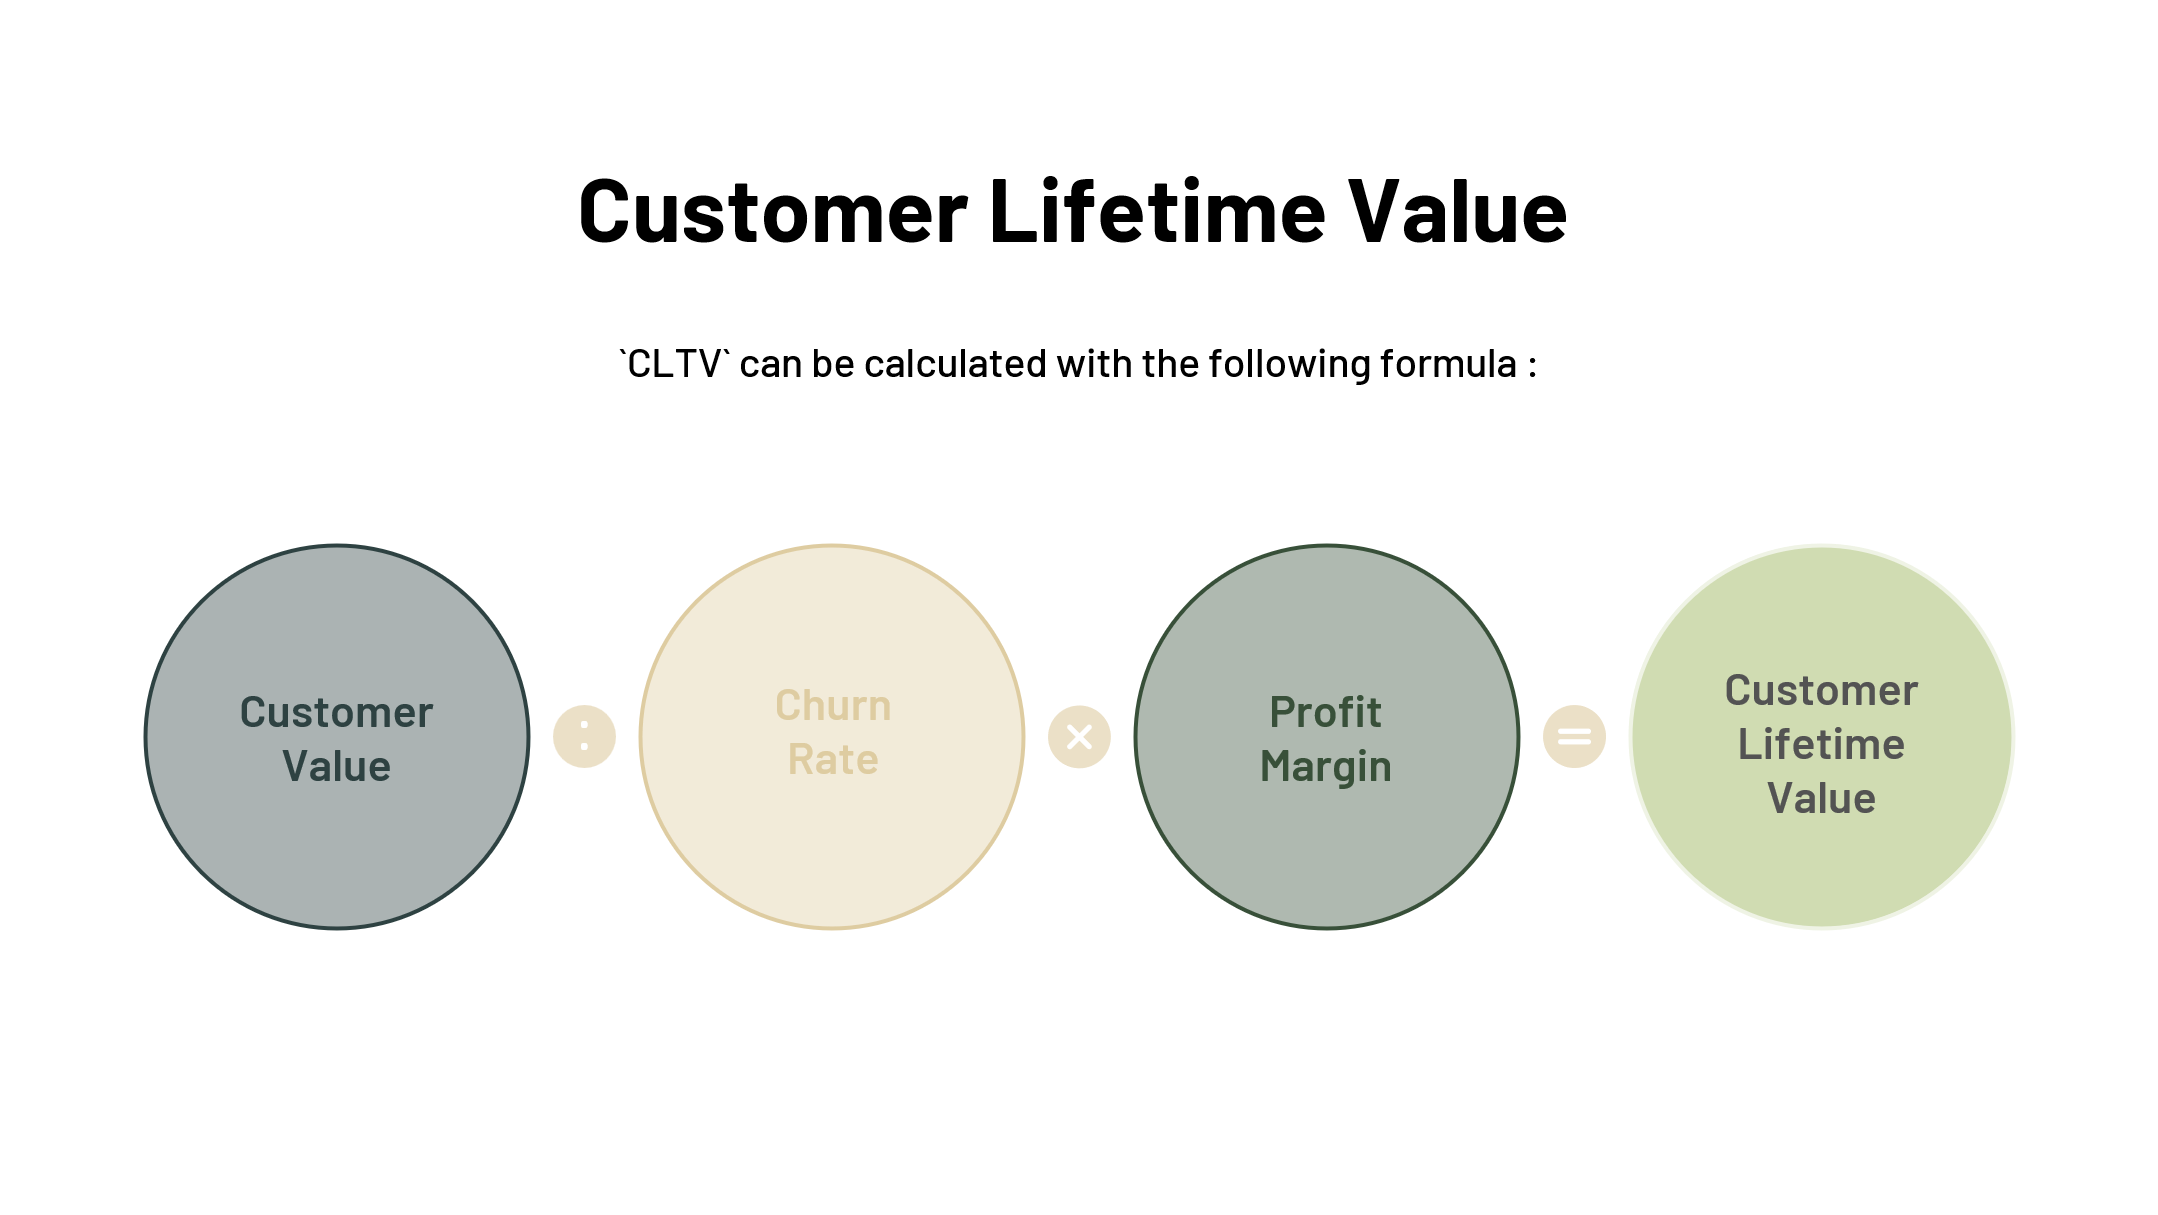

1. Customer Value:
    * Customer Value = Average Order Value (AOV) x Purchase Frequency
    * Average Order Value (AOV) = Total Price / Total Transaction
    * Purchase Frequency = Total Transaction / Total Number of Customers
<br>
<br>
2. Churn Rate:
    * Churn Rate = 1 - Repeat Rate
    * Repeat Rate = (Number of customers making multiple purchases) / (Total customers)
<br>
<br>
3. Profit Margin:
    * Profit Margin = Total Price x 0.10 (Assumed Profit Margin)
<br>
<br>    
4. CLTV Calculation:
    * CLTV = (Customer Value / Churn Rate) x Profit Margin

# Load the Data

In [71]:
dff = data.copy()

In [72]:
dff = dff[dff['Customer ID'] != 'User Non Login']

## Feature Engginering

In [73]:
CLTV = dff.groupby('Customer ID').agg({"Quantity": lambda x: x.sum(),
                             "TotalCost": "sum"})
CLTV.rename(columns={'Quantity': 'Total_Unit',
                         'TotalCost': 'Total_Price'}, inplace=True)

cltv_df = CLTV.reset_index()

In [74]:
cltv_df

,Customer ID,Total_Unit,Total_Price
0,12346.0,53,-51.74
1,12347.0,2967,4921.53
2,12348.0,2714,2019.40
3,12349.0,1619,4404.54
4,12350.0,197,334.40
...,...,...,...
5934,18283.0,1679,2664.90
5935,18284.0,493,436.68
5936,18285.0,145,427.00
5937,18286.0,592,1188.43


In [75]:
summary_df = summary_df.drop(['Cancelled'], axis=1).reset_index()

In [76]:
summary_df

,Customer ID,RealOrder
0,12346.0,12
1,12347.0,8
2,12348.0,5
3,12349.0,4
4,12350.0,1
...,...,...
5935,18284.0,1
5936,18285.0,1
5937,18286.0,2
5938,18287.0,7


In [77]:
cltv_df['Customer ID'] = cltv_df['Customer ID'].astype(object)
cltv_df = pd.merge(cltv_df, summary_df, how='inner', on='Customer ID')

In [78]:
cltv_df.rename(columns={ 'RealOrder': 'Total_Transaction'}, inplace=True)

In [79]:
cltv_df

,Customer ID,Total_Unit,Total_Price,Total_Transaction
0,12346.0,53,-51.74,12
1,12347.0,2967,4921.53,8
2,12348.0,2714,2019.40,5
3,12349.0,1619,4404.54,4
4,12350.0,197,334.40,1
...,...,...,...,...
5934,18283.0,1679,2664.90,22
5935,18284.0,493,436.68,1
5936,18285.0,145,427.00,1
5937,18286.0,592,1188.43,2


### Create average order value (AOV)

`Average Order Value (AOV) = Total Price / Total Transaction`

In [80]:
cltv_df['AOV'] = cltv_df['Total_Price'] / cltv_df['Total_Transaction']

### Create purchase frequency

`Purchase Frequency = Total Transaction / Total Number of Customers`

In [81]:
cltv_df['Frequency_of_purchase'] = cltv_df['Total_Transaction'] / cltv_df.shape[0]

### Create customer value

`Customer Value = Average Order Value (AOV) x Purchase Frequency`

In [82]:
cltv_df['Customer_values'] = cltv_df['AOV'] * cltv_df['Frequency_of_purchase']

### Create churn rate

`Churn Rate = 1 - Repeat Rate` <br>
`Repeat Rate = (Number of customers making multiple purchases) / (Total customers)`

In [83]:
Repeat_Rate = cltv_df[cltv_df["Total_Transaction"] > 1].shape[0] / cltv_df.shape[0]
Churn_Rate = 1 - Repeat_Rate

In [84]:
Churn_Rate

0.28354941909412357

### Create profit margin

`Profit Margin = Total Price x 0.10 (Assumed Profit Margin)`

In [85]:
cltv_df["Profit_margin"] = cltv_df["Total_Price"] * 0.10

### Create customer lifetime value

`CLTV = (Customer Value / Churn Rate) x Profit Margin`

In [86]:
cltv_df["CLTV"] = (cltv_df["Customer_values"] / Churn_Rate) * cltv_df["Profit_margin"]

In [87]:
cltv_df

,Customer ID,Total_Unit,Total_Price,Total_Transaction,AOV,Frequency_of_purchase,Customer_values,Profit_margin,CLTV
0,12346.0,53,-51.74,12,-4.311667,0.002021,-0.008712,-5.174,0.158968
1,12347.0,2967,4921.53,8,615.191250,0.001347,0.828680,492.153,1438.328833
2,12348.0,2714,2019.40,5,403.880000,0.000842,0.340024,201.940,242.160116
3,12349.0,1619,4404.54,4,1101.135000,0.000674,0.741630,440.454,1152.017376
4,12350.0,197,334.40,1,334.400000,0.000168,0.056306,33.440,6.640342
...,...,...,...,...,...,...,...,...,...
5934,18283.0,1679,2664.90,22,121.131818,0.003704,0.448712,266.490,421.715678
5935,18284.0,493,436.68,1,436.680000,0.000168,0.073528,43.668,11.323600
5936,18285.0,145,427.00,1,427.000000,0.000168,0.071898,42.700,10.827138
5937,18286.0,592,1188.43,2,594.215000,0.000337,0.200106,118.843,83.869707


## Segmentation based on CLTV

In [88]:
cltv_df["Segments"] = pd.qcut(cltv_df["CLTV"], 4, labels= ["D", "C", "B", "A"])

In [89]:
cltv_df

,Customer ID,Total_Unit,Total_Price,Total_Transaction,AOV,Frequency_of_purchase,Customer_values,Profit_margin,CLTV,Segments
0,12346.0,53,-51.74,12,-4.311667,0.002021,-0.008712,-5.174,0.158968,D
1,12347.0,2967,4921.53,8,615.191250,0.001347,0.828680,492.153,1438.328833,A
2,12348.0,2714,2019.40,5,403.880000,0.000842,0.340024,201.940,242.160116,B
3,12349.0,1619,4404.54,4,1101.135000,0.000674,0.741630,440.454,1152.017376,A
4,12350.0,197,334.40,1,334.400000,0.000168,0.056306,33.440,6.640342,C
...,...,...,...,...,...,...,...,...,...,...
5934,18283.0,1679,2664.90,22,121.131818,0.003704,0.448712,266.490,421.715678,A
5935,18284.0,493,436.68,1,436.680000,0.000168,0.073528,43.668,11.323600,C
5936,18285.0,145,427.00,1,427.000000,0.000168,0.071898,42.700,10.827138,C
5937,18286.0,592,1188.43,2,594.215000,0.000337,0.200106,118.843,83.869707,B


In [90]:
cltv_df.groupby("Segments").agg({"count", "mean", "sum"})

Customer ID                     Total_Unit                     \
                 sum count          mean        sum count         mean   
Segments                                                                 
D         22738582.0  1470  15468.423129     178485  1470   121.418367   
C         22575729.0  1469  15368.093261     483073  1469   328.844792   
B         22435701.0  1469  15272.771273    1235465  1469   841.024506   
A         22273401.0  1470  15151.973469    8144580  1470  5540.530612   

           Total_Price                    Total_Transaction  ...  \
                   sum count         mean               sum  ...   
Segments                                                     ...   
D         2.688785e+05  1470   182.910571              1962  ...   
C         8.071101e+05  1469   549.428245              3604  ...   
B         2.010989e+06  1469  1368.951289              7021  ...   
A         1.326406e+07  1470  9023.172029             24382  ...   

         Frequency_of_purchase Customer_values                 Profit_margin  \
                          mean             sum count      mean           sum   
Segments                                                                       
D                     0.000225       45.273369  1470  0.030798  2.688785e+04   
C                     0.000413      135.899999  1469  0.092512  8.071101e+04   
B                     0.000805      338.607416  1469  0.230502  2.010989e+05   
A                     0.002793     2233.383210  1470  1.519308  1.326406e+06   

                                    CLTV                      
         count        mean           sum count          mean  
Segments                                                      
D         1470   18.291057  3.594713e+03  1470      2.445383  
C         1469   54.942825  2.843944e+04  1469     19.359725  
B         1469  136.895129  1.772165e+05  1469    120.637502  
A         1470  902.317203  6.838849e+07  1470  46522.780575  

[4 rows x 27 columns]

In [91]:
segment_stats = cltv_df.groupby("Segments")[["AOV", "Total_Transaction", "Profit_margin"]].mean()
segment_stats

,AOV,Total_Transaction,Profit_margin
Segments,,,
D,153.704796,1.334694,18.291057
C,285.312431,2.453370,54.942825
B,375.300544,4.779442,136.895129
A,570.998704,16.586395,902.317203


# Visualization

In [92]:
categories = ['AOV','Total_Transaction','Profit_margin']
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=segment_stats.iloc[3].to_list(),
      theta=categories,
      fill='toself',
      name='A'
))
fig.add_trace(go.Scatterpolar(
      r=segment_stats.iloc[2].to_list(),
      theta=categories,
      fill='toself',
      name='B'
))
fig.add_trace(go.Scatterpolar(
      r=segment_stats.iloc[1].to_list(),
      theta=categories,
      fill='toself',
      name='C'
))
fig.add_trace(go.Scatterpolar(
      r=segment_stats.iloc[0].to_list(),
      theta=categories,
      fill='toself',
      name='D'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1000]
    )),
  showlegend=True,
  width=900,
  height=900
)

fig.show()

In [93]:
# List of metrics
metrics = ['AOV', 'Total_Transaction', 'Profit_margin']

# Create a subplot with 1 row and len(metrics) columns
fig = make_subplots(rows=1, cols=len(metrics), subplot_titles=metrics)

# Loop through each metric and create a bar chart
for i, metric in enumerate(metrics, start=1):
    fig_i = px.bar(segment_stats, x=segment_stats.index, y=segment_stats[metric], width=1000, height=600, template='seaborn')
    fig_i.update_xaxes(title='Segments')
    fig_i.update_yaxes(title='count')
    fig.add_trace(fig_i['data'][0], row=1, col=i)

# Show the combined plot
fig.show()

# Business Recommendation

1. At Risk
    * Personalized Engagement: Engage with at-risk customers through personalized messages, seeking their feedback and addressing any concerns or issues they may have. This proactive approach demonstrates your commitment to retaining their business.
    * Win-Back Offers: Design tailored win-back offers that address the specific reasons behind their lapse in purchases. This targeted approach increases the likelihood of re-engagement.
    * Reactivation Campaigns: Implement targeted reactivation campaigns aimed at reconnecting with inactive customers. Offer a special welcome-back gift or discount to encourage their return. <br>

2. Need Attention <br>
    * Personalized Outreach: Instead of generic promotional emails, tailor outreach to individual customers based on their past purchases, browsing history, and interests. This personalized approach increases relevance and engagement.
    * Relevancy in Promotions: Ensure that promotions and discounts align with the preferences and needs of customers in this cluster. Avoid overwhelming them with irrelevant offers that fail to capture their attention.
    * Loyalty Program Tiers: Consider introducing tiered loyalty programs, providing progressively attractive benefits as customers increase their engagement and repeat purchases. <br>
3. Loyal Customers
    * Exclusive Shopping Experiences: Create exclusive shopping experiences for loyal customers, such as private sales, early access to new products, or personalized consultations with product experts.
    * Subscription Services: Offer subscription services tailored to their preferences, providing regular deliveries of their favorite products or exclusive access to new items.
    * Community Access: Create an online community or forum exclusively for loyal customers, fostering a sense of belonging and encouraging peer-to-peer engagement.<br>

4. The Champion
    * Exclusive Access: Provide exclusive access to new products, limited-edition items, or special events as a reward for their loyalty. This exclusivity enhances their sense of value and appreciation.
    * Personalized Recommendations: Utilize purchase history and expressed preferences to provide personalized product recommendations, showcasing complementary items or upgrades that align with their interests.
    * Early Bird Benefits: Offer early access to sales, exclusive discounts, or sneak peeks of new products to VIP customers, further solidifying their loyalty. <br>   
* Recommendation for non login users
     1. Make the login process easier <br>
         One of the reasons why consumers do not log in is because the process is considered too complicated, so improvements need to be made to make the login process easier by providing more diverse login options, for example by using a social media account or email.

     2. Offer incentives for consumers who log in <br>
         Offer incentives to consumers who log in, for example in the form of discounts, vouchers or rewards points. This can encourage consumers to log in and make purchases more often.


# CSV Output

In [94]:
final = cltv_df.copy()
final['RFM_cluster'] = kmeans.labels_

In [95]:
mapping = {
    0: "Need Attention",
    1: "At Risk",
    2: "The Champion",
    3: "Loyal Customers"
}
final["RFM_cluster"].replace(mapping, inplace=True)

In [96]:
final = final.sort_values(by='Total_Price', ascending=False)

In [97]:
final.head(10)

,Customer ID,Total_Unit,Total_Price,Total_Transaction,AOV,Frequency_of_purchase,Customer_values,Profit_margin,CLTV,Segments,RFM_cluster
5753,18102.0,180415,570380.61,145,3933.659379,0.024415,96.039840,57038.061,1.931912e+07,A,The Champion
2298,14646.0,364580,523342.07,151,3465.841523,0.025425,88.119561,52334.207,1.626407e+07,A,The Champion
1808,14156.0,162245,296063.44,156,1897.842564,0.026267,49.850722,29606.344,5.205081e+06,A,The Champion
2562,14911.0,141500,265757.91,398,667.733442,0.067015,44.747922,26575.791,4.194018e+06,A,The Champion
5101,17450.0,80190,231390.55,51,4537.069608,0.008587,38.961197,23139.055,3.179429e+06,A,Loyal Customers
1347,13694.0,184534,190020.84,143,1328.817063,0.024078,31.995427,19002.084,2.144176e+06,A,Loyal Customers
5162,17511.0,115449,168491.62,60,2808.193667,0.010103,28.370369,16849.162,1.685833e+06,A,Loyal Customers
69,12415.0,91019,143269.29,28,5116.760357,0.004715,24.123470,14326.929,1.218889e+06,A,Loyal Customers
4335,16684.0,101095,141502.25,55,2572.768182,0.009261,23.825939,14150.225,1.189008e+06,A,Loyal Customers
2712,15061.0,73554,124961.98,127,983.952598,0.021384,21.040913,12496.198,9.272860e+05,A,Loyal Customers


In [98]:
# Csv Output
final.to_csv("final.csv")